# Imports

In [1]:
# If updates on imported files aren't detected, restart the kernel (we'll need to find an automatic solution for this)

import numpy as np
from icecream import ic

from typing import List, Tuple, Dict


# Evolution Helper

In [2]:
import random
from typing import List
from gxgp.node import Node
from utils.operations_dict import basic_function_set, complex_function_set

### Tree Generation

In [3]:
def generate_random_tree(max_height: int, pc: float, terminal_list: List[str],
                         constants: list[float] = None, p_pick_constant: float = 0.2, p_cut_tree: float = 0.2,
                         verbose: bool = False, cur_depth: int = 0) -> Node:
    """
    Generate a random symbolic expression tree.

    Mandatory Parameters
    ----------
    max_height : int
        The maximum height of the tree. The height of a tree is the length of the longest path from the root to a leaf (e.g. height of a leaf is 0).
    pc : float
        The probability of choosing a complex function over a basic function.
    terminal_list : List[str]
        The terminal list to choose from. Example: ['x0', 'x1', 'x2']

    Optional Parameters
    ----------
    constants : list[float]
        A list of constants that can be used in the tree (default is None).
    p_pick_constant : float
        The probability of choosing a constant over a terminal (default is 0.2).
    p_cut_tree : float
        The probability of cutting the tree early (default is 0.2).    
    verbose : bool    
        Whether to print debug information (default is False).
    cur_depth : int
        The exploration depth (e.g. depth of root is 0)

    Returns
    -------
    Node
        A Node object representing the root of the tree.
    """
    indent = ' ' * (cur_depth * 2)

    # Cut the tree early with probability 0.2
    if (random.random() < p_cut_tree) or max_height == 0:  
        # If constants are provided, choose one with probability p_pick_constant
        if constants is not None and random.random() < p_pick_constant: 
            terminal = random.choice(constants) 
        # Otherwise, pick from the terminal set
        else:                                                
            terminal = random.choice(terminal_list)
        
        if verbose: print(f"{indent}Picked terminal: {terminal}")

        # Set the height of the node to 0
        my_node = Node(terminal)
        my_node.set_height(0)
        return my_node
    else:
        # Choose a complex function with probability pc
        if random.random() < pc:                       
            func = random.choice(list(complex_function_set.keys()))
            if verbose: print(f"{indent}Chose complex function {func}")
            num_children = complex_function_set[func].__code__.co_argcount  # Numero di argomenti della funzione
            children = [generate_random_tree(max_height - 1, pc, terminal_list, constants, p_pick_constant, p_cut_tree, verbose, cur_depth + 1)
                        for _ in range(num_children)]
            
            # Set height
            cur_height = max([child.get_height() for child in children]) + 1
            my_node = Node(complex_function_set[func], children, name=func)
            my_node.set_height(cur_height)
            return my_node
        # Otherwise, choose a basic function
        else:                                           
            func = random.choice(list(basic_function_set.keys()))
            if verbose: print(f"{indent}Chose basic function {func}")
            num_children = basic_function_set[func].__code__.co_argcount  # Numero di argomenti della funzione
            children = [generate_random_tree(max_height - 1, pc, terminal_list, constants, p_pick_constant, p_cut_tree, verbose, cur_depth + 1)
                        for _ in range(num_children)]
            # Set height
            cur_height = max([child.get_height() for child in children]) + 1
            my_node = Node(basic_function_set[func], children, name=func)
            my_node.set_height(cur_height)
            return my_node

### Mutations

In [4]:
def point_mutation(Tree: Node, terminal_list: List[str], constants: list[float] = None, p_pick_constant: float = 0.2, pc: float = 0.2) -> Node:
    """
    Mutate a tree by changing a random node to a new random node.

    Parameters
    ----------
    Tree : Node
        The tree to mutate.
    terminal_list : List[str]
        The terminal list to choose from. Example: ['x0', 'x1', 'x2']
    constants : list[float]
        A list of constants that can be used in the tree.
    p_pick_constant : float
        The probability of choosing a constant over a terminal.
    pc : float
        The probability of choosing a complex function over a basic function.

    Returns
    -------
    Node
        The mutated tree.
    """

    # Get the list of nodes in the tree
    node = Tree.get_random_node()

    # If the node is a terminal, change it to a new terminal
    if node.is_leaf:
        if constants is not None and random.random() < p_pick_constant:
            terminal = random.choice(constants)
        else:
            terminal = random.choice(terminal_list)
        node.set_func(terminal)
        return Tree
    # Otherwise, change it to a new function maintaining the arity
    else:
        if random.random() < pc:
            while True:
                func = random.choice(list(complex_function_set.keys()))
                arity = complex_function_set[func].__code__.co_argcount
                if arity == node._arity:
                    break
            node.set_func(complex_function_set[func], name=func)
        else:
            while True:
                func = random.choice(list(basic_function_set.keys()))
                arity = basic_function_set[func].__code__.co_argcount
                if arity == node._arity:
                    break
            node.set_func(basic_function_set[func], name=func)
        return Tree
    
def subtree_mutation(Tree: Node, terminal_list: List[str], constants: list[float] = None, p_pick_constant: float = 0.2, pc: float = 0.2, height: int = 3, verbose: bool = False) -> Node:
    """
    Mutate a tree by changing a random subtree to a new random subtree.

    Parameters
    ----------
    Tree : Node
        The tree to mutate.
    terminal_list : List[str]
        The terminal list to choose from. Example: ['x0', 'x1', 'x2']
    constants : list[float]
        A list of constants that can be used in the tree.
    p_pick_constant : float
        The probability of choosing a constant over a terminal.
    pc : float
        The probability of choosing a complex function over a basic function.
    height : int
        The maximum height of the new subtree.

    Returns
    -------
    Node
        The mutated tree.
    """

    # Get the list of nodes in the tree
    node = Tree.get_random_node()

    if verbose:
        print(f"Node to mutate: {node._str} at height {node._height}")

    new_subtree = generate_random_tree(height, pc, terminal_list, constants, p_pick_constant)
    node = node.replace_tree(new_subtree)
    return Tree

# Load Data

In [5]:
from gxgp import Node

problem = np.load('problem_0.npz')
input = problem['x']
labels = problem['y']

print("Input shape:", input.shape, " Example of sample: ", input[:, 0])
print("Labels shape:", labels.shape, " Example of label: ", labels[0])

# Terminal set
terminal_list = ['x' + str(i) for i in range(input.shape[0])]

print("terminal_list: ", terminal_list)

Input shape: (2, 1000)  Example of sample:  [ 2.37857096 -0.74681473]
Labels shape: (1000,)  Example of label:  2.242710018984468
terminal_list:  ['x0', 'x1']


# Tree Generation
You can fine tune the size of the output by modifying draw() from draw.py

Chose basic function add
  Picked terminal: x0
  Chose basic function sqrt
    Picked terminal: 12.0
Drawing tree with height 2...


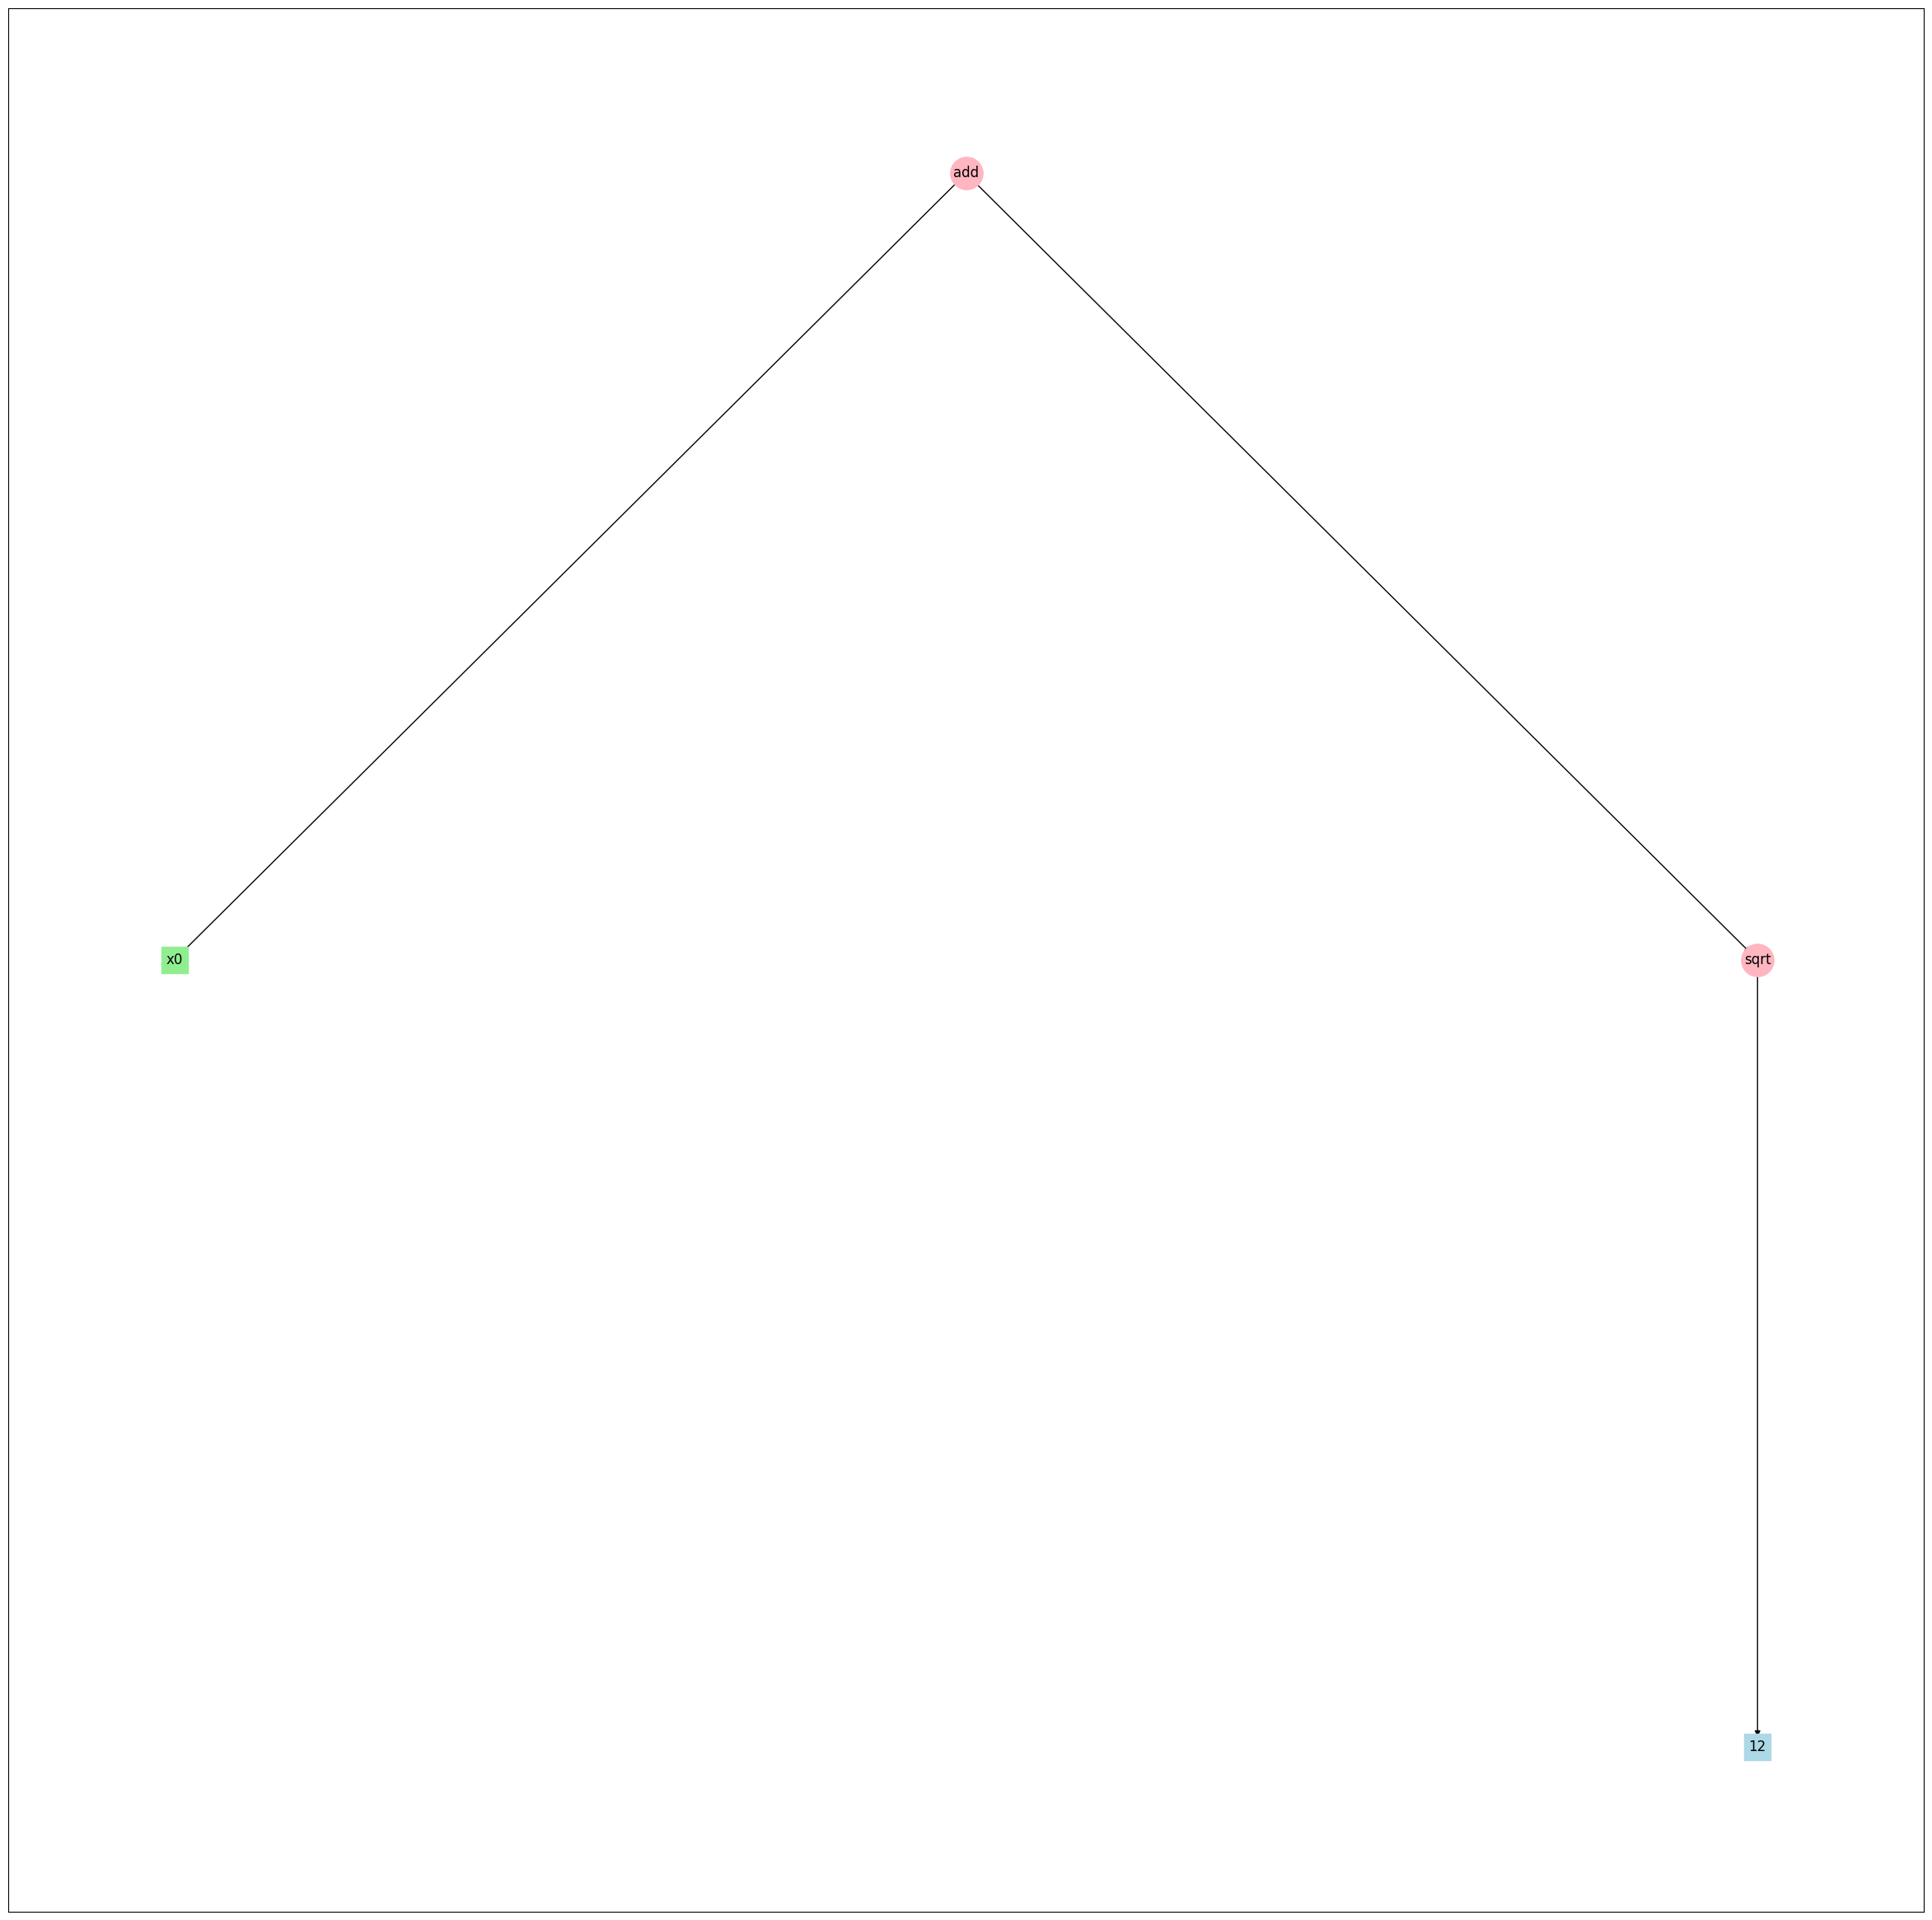

In [6]:
from utils.terminal_constants import crammed_constants

height = 3
initialized = generate_random_tree(height, 0.2, terminal_list, constants=crammed_constants, p_pick_constant=0.4, p_cut_tree=0.2, verbose=True)
initialized.draw()



Create input formatted

In [7]:
vars = {'x'+str(i): input[:,0][i] for i in range(input.shape[0])}
initialized(**vars)

np.float64(5.8426725701540825)

In [8]:
# Fitness
def fitness(mytree, vars, labels):
    return 100*np.square(labels - mytree(**vars)).sum()/len(labels)

Node to mutate: 12 at height 0
Drawing tree with height 2...


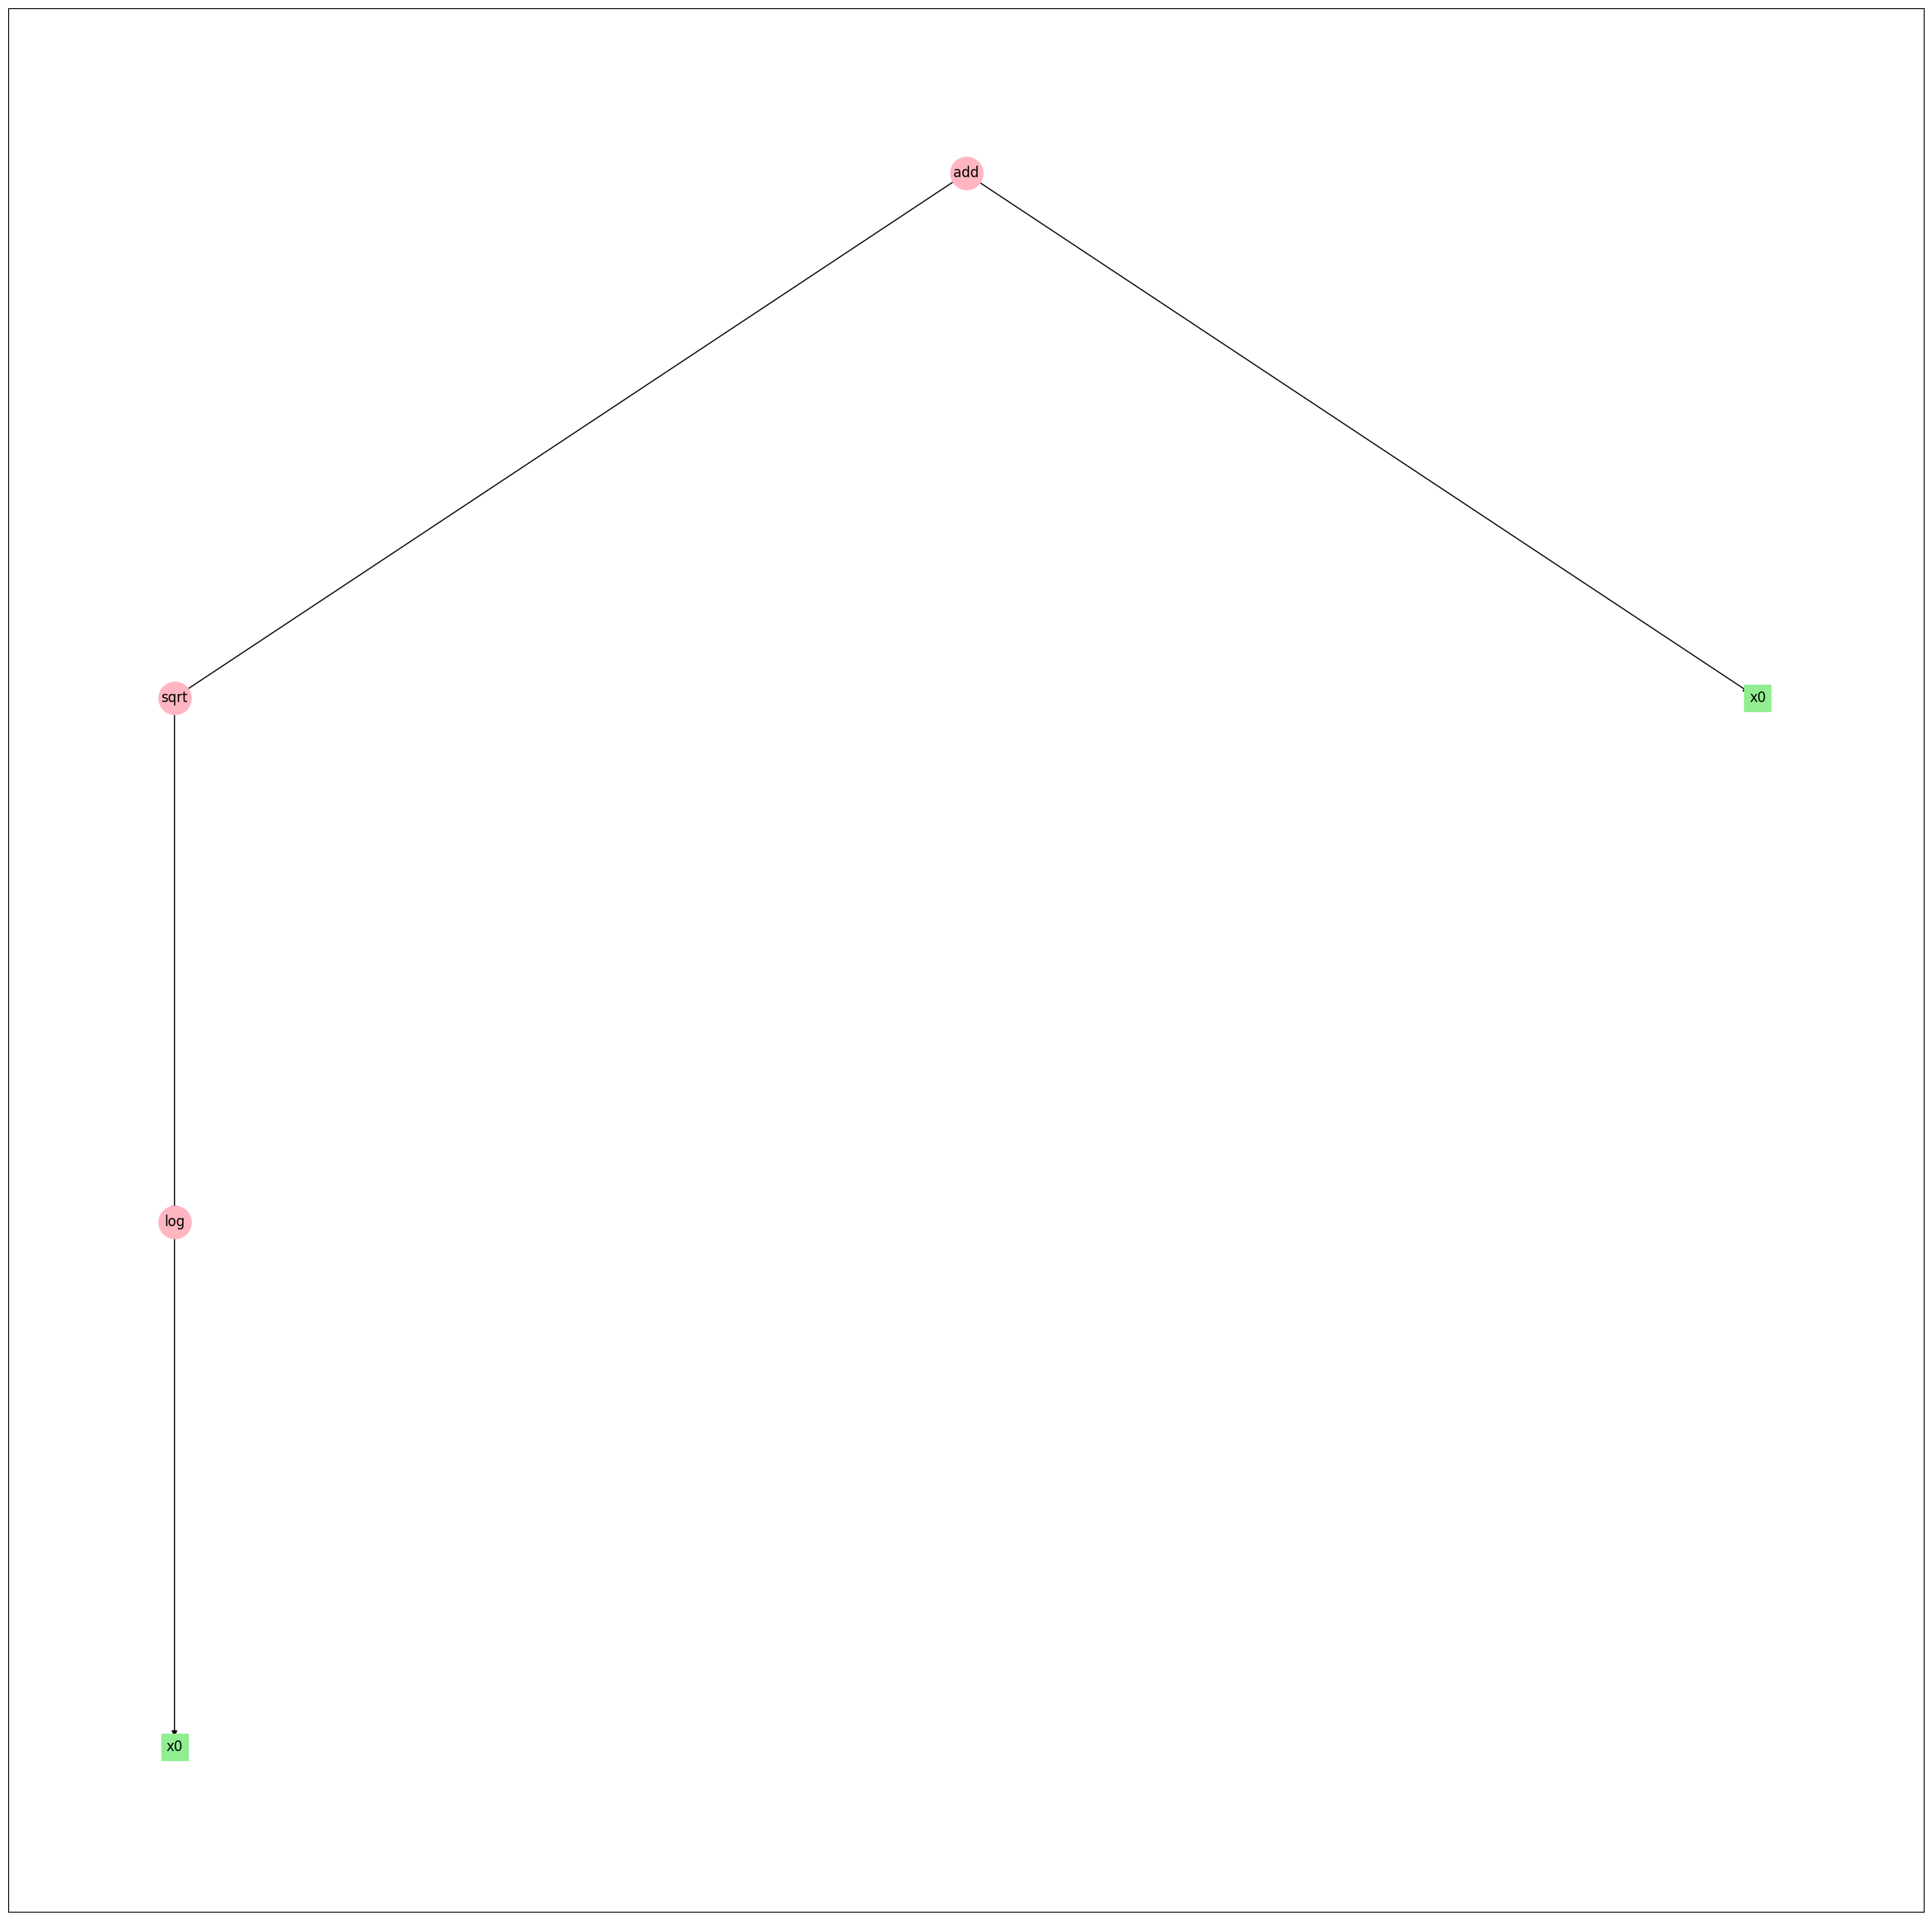

In [9]:
from gxgp.gp_common import xover_swap_subtree
# Xover
def xover(tree1, tree2):
    return xover_swap_subtree(tree1, tree2)

# initialized.subtree.pop().draw() # this procedure is really similar to get_random_node, except there we use a list and random.choice
subtree_mutation(initialized, terminal_list, crammed_constants, 0.2, verbose=True).draw()

## Training